In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.integrate import odeint
from glob import glob
import pickle
from scipy.optimize import curve_fit
from pathlib import Path
from nufeb_tools import utils,plot
import seaborn as sns
from scipy import stats
from scipy import interpolate
from sklearn.metrics import r2_score

In [30]:
#high = utils.get_data(directory= r'C:\Users\sakkosjo\OneDrive - Michigan State University\Documents\runs\Run_0_44_52_1_2021-07-16')
#med = utils.get_data(directory= r'C:\Users\sakkosjo\OneDrive - Michigan State University\Documents\runs\Run_0_47_24_1_2021-07-16')
#low = utils.get_data(directory= r'C:\Users\sakkosjo\OneDrive - Michigan State University\Documents\runs\Run_0_83_22_1_2021-07-16')
folders = [r'D:\runs\Run_0_100_12_1_2021-07-16',r'D:\runs\Run_0_100_8_1_2021-07-16',r'D:\runs\Run_0_100_19_1_2021-07-16']
types = [Path(x) / 'Results/ntypes.csv' for x in folders]
biomass = [Path(x) / 'Results/biomass.csv' for x in folders]
Cons = [Path(x) / 'Results/avg_concentration.csv' for x in folders]
ExpPath = r'../experimental-data/ecw growth.xlsx'
Control = pd.read_excel(ExpPath)
labels = ['20 g/L','10 g/L','5 g/L']


In [31]:
Control['Time'].to_numpy()

array([ 0. ,  6.5, 10. , 12. , 14.5, 16.5, 18.5, 22.5, 26.5, 33. , 48. ,
       58. , 77. , 98. ])

In [32]:
Control['OD'].to_numpy()

array([0.003, 0.025, 0.11 , 0.245, 0.388, 0.44 , 0.504, 0.64 , 0.725,
       0.788, 0.79 , 0.8  , 0.825, 0.83 ])

In [33]:
Control

,Time,OD
0,0.0,0.003
1,6.5,0.025
2,10.0,0.110
3,12.0,0.245
4,14.5,0.388
5,16.5,0.440
6,18.5,0.504
7,22.5,0.640
8,26.5,0.725
9,33.0,0.788


In [57]:
SucroseMW = 342.3
O2MW = 32
CO2MW = 44.01
dens = 1e9
Volume = 1e-4*1e-4*1e-5 #m^3
mlm3 = 1e6 #mL/m^3
cellsperOD=8e8 #cells/mL @OD 1
CellNum2OD = Volume*cellsperOD*mlm3
#CellNum2OD = Volume/1e-9
Biomass2OD = 1e12
tStep2Days = 10/3600/24
sucs = np.linspace(0,1,6)
pctC = 0.5
light = 1.00e-01 #kg/m^3
co2 = 4e-1
mu_max = 0.047*24 #2.25e-05# 1/d
K_m_light = 3.5e-04
K_m_co2 = 5e-2
def cells2OD(x):
    return (x+4e7)*1e9*Volume*1e-4
    
def func(x,K,r,N0):
    return K/(1  + ((K-N0)/N0)*np.exp(-r*x))



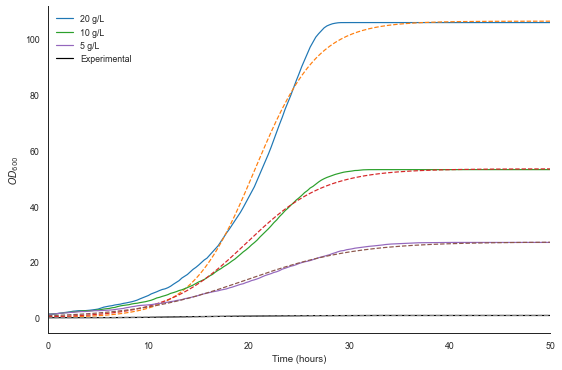

In [69]:
sns.set_context('paper')
sns.set_style('white')
mus =list()
f, ax = plt.subplots(figsize=(9,6))
for path,label in zip(types,labels):
    df = pd.read_csv(path,usecols=[0,1],names=['Time','Cells'],skiprows=1,delimiter='	')
    df.index = df.Time/60/60*10 #convert timesteps (10s) to days
    df.index.name='Hours'
    df['OD'] = df.iloc[:,1]/CellNum2OD
    ax.plot(df.OD,label=label)
    popt, pcov = curve_fit(func,df.index.values,df.OD,p0=[0.80309017, 0.24164053, 0.01670965])
    mus.append(popt[1])
    ax.plot(df.index.values,func(df.index.values,*popt),ls='--')

ax.legend().remove()
ax.set_xlim([0,50])
ax.plot(Control.Time,Control.OD,label='Experimental',c='k')
popt, pcov = curve_fit(func,Control.Time,Control.OD,p0=[0.80309017, 0.24164053, 0.01670965])
ax.plot(Control.Time,func(Control.Time,*popt),ls='--',c='grey')
ax.set_xlabel('Time (hours)')
ax.set_ylabel(r'$OD_{600}$')
ax.legend(frameon=False)

sns.despine()

In [59]:
growth = pd.DataFrame([mus,[20,10,5]]).T
growth.columns=['mu','Sucrose']
growth

,mu,Sucrose
0,0.320247,20.0
1,0.255373,10.0
2,0.183656,5.0


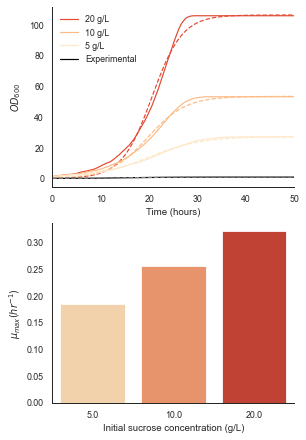

In [70]:
#f,axes = plt.subplots(nrows=4,ncols=2,figsize=(12,15))
colors = ['#e34a33','#fdbb84','#fee8c8']
fig = plt.figure(constrained_layout=True, figsize=(7.5,6))
gs0 = gridspec.GridSpec(4, 2, figure=fig)
sns.set_context('paper')
sns.set_style('white')

ax2 = fig.add_subplot(gs0[2:, 0])
ax1 = fig.add_subplot(gs0[:2, 0])

#ax6 = fig.add_subplot(gs0[3,1])
#ax3 = fig.add_subplot(gs0[0,1],sharex=ax6)


mus =list()
for i,(path,label) in enumerate(zip(types,labels)):
    df = pd.read_csv(path,usecols=[0,1],names=['Time','Cells'],skiprows=1,delimiter='	')
    df.index = df.Time/60/60*10 #convert timesteps (10s) to days
    df.index.name='Hours'
    df['OD'] = df.iloc[:,1]/CellNum2OD
    ax1.plot(df.OD,label=label,c=colors[i])
    popt, pcov = curve_fit(func,df.index.values,df.OD,p0=[0.80309017, 0.24164053, 0.01670965])
    mus.append(popt[1])
    ax1.plot(df.index.values,func(df.index.values,*popt),ls='--',c=colors[i])

ax1.legend().remove()
ax1.set_xlim([0,50])
ax1.plot(Control.Time,Control.OD,label='Experimental',c='k')
popt, pcov = curve_fit(func,Control.Time,Control.OD,p0=[0.80309017, 0.24164053, 0.01670965])
ax1.plot(Control.Time,func(Control.Time,*popt),ls='--',c='grey')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel(r'$OD_{600}$')
ax1.legend(frameon=False)


sns.barplot(x='Sucrose',y='mu',data=growth,ax=ax2,palette='OrRd')
ax2.set_xlabel('Initial sucrose concentration (g/L)')
ax2.set_ylabel(r'$\mu_{max} (hr^{-1})$ ')




#ax1.plot(IPTG.Time,IPTG.OD,label='+IPTG',c='grey',ls='--')
#sns.lineplot(x='Time',y='OD600',hue='SucroseExport',data=df,ax=ax1,palette='mako')
#ax2.plot(Control.Time,Control.Sucrose,label='Control',c='red',ls='--')
#ax2.plot(IPTG.Time,IPTG.Sucrose,label='+IPTG',c='grey',ls='--')
#sns.lineplot(x='Time',y='Sucrose',hue='SucroseExport',data=df,ax=ax2,palette='mako')
sns.despine()


#sns.scatterplot(x='SucroseExport',y='Productivity',data=df,ax=ax3,color='#92c5de')
#sns.barplot(x='SucroseExport',y='CellMass',data=df,ax=axes[1,1])
#width = 1/len(Run_folders)
#ax4.bar(ExportRatio,df.RelCell.unique(),width,label='Cell Biomass',edgecolor='k',color='#2ca25f')
#ax4.bar(ExportRatio,df.RelSuc.unique(),width,bottom=df.RelCell.unique(),label='Sucrose Biomass',edgecolor='k',color='#92c5de')

#ax5.bar(ExportRatio,df.CellMass.unique(),width,label='Cell Biomass',edgecolor='k',color='#2ca25f')
#ax5.bar(ExportRatio,df.SucMass.unique(),width,bottom=df.CellMass.unique(),label='Sucrose Biomass',edgecolor='k',color='#92c5de')
#sns.scatterplot(x='SucroseExport',y='Ratio',data=df,ax=ax6,color='#92c5de')
#plt.setp(ax1.get_xticklabels(), visible=False)

#ax3.set_xlabel('')

fig.align_ylabels()
#fig.savefig('validationEC.png',dpi=600)
#f.tight_layout()



In [61]:
#platefile = r'./ECW20210730.xlsx'
platefile = r'../experimental-data/20210824 Growth curve.xlsx'
ecw = pd.read_excel(platefile,sheet_name='Sheet1', nrows=122)
ecw

,Time,Hours,T° 600,A1,A2,A3,A4,A5,A6,A7,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,00:14:10,0.236111,32.0,0.083,0.175,0.198,0.203,0.203,0.196,0.209,...,0.248,0.240,0.243,0.250,0.254,0.239,0.240,0.233,0.231,0.190
1,00:29:10,0.486111,32.0,0.083,0.084,0.083,0.082,0.083,0.083,0.083,...,0.193,0.201,0.213,0.217,0.218,0.203,0.198,0.189,0.175,0.082
2,00:44:10,0.736111,32.0,0.083,0.084,0.083,0.082,0.083,0.083,0.083,...,0.088,0.137,0.158,0.171,0.172,0.152,0.134,0.104,0.082,0.082
3,00:59:10,0.986111,32.0,0.084,0.085,0.083,0.083,0.083,0.083,0.083,...,0.083,0.082,0.082,0.083,0.086,0.084,0.082,0.083,0.082,0.082
4,01:14:10,1.236111,32.0,0.084,0.085,0.083,0.083,0.083,0.083,0.083,...,0.083,0.082,0.082,0.083,0.083,0.083,0.082,0.082,0.082,0.082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,1900-01-01 05:29:10,29.486111,32.0,0.389,0.400,0.411,0.412,0.412,0.395,0.367,...,0.383,0.377,0.379,0.384,0.351,0.343,0.339,0.325,0.087,0.083
118,1900-01-01 05:44:10,29.736111,32.0,0.390,0.401,0.413,0.415,0.414,0.397,0.367,...,0.385,0.380,0.382,0.386,0.352,0.345,0.340,0.328,0.088,0.083
119,1900-01-01 05:59:10,29.986111,32.0,0.391,0.403,0.413,0.414,0.414,0.398,0.368,...,0.385,0.380,0.383,0.387,0.352,0.344,0.342,0.329,0.088,0.083
120,1900-01-01 06:14:10,30.236111,32.1,0.392,0.404,0.415,0.416,0.415,0.400,0.369,...,0.388,0.382,0.385,0.389,0.354,0.347,0.344,0.331,0.088,0.082


R-squared: 0.734266
mu: 0.005793


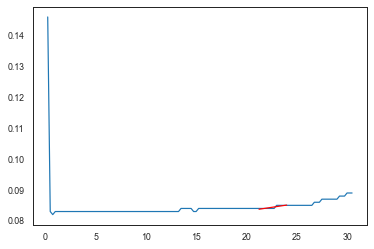

In [62]:

fit_windows = {20 : [10,12], 18 : [10,12],16 : [10,12],14 : [10,12],12 : [10,12],10 : [10,12],5: [13,16],4: [15,18],3: [18,20],2: [21,24],1: [21,24],0: [10,12]}
bounds = [21,24]
well = 'A11'
x= ecw[(ecw.Hours > bounds[0]) & (ecw.Hours < bounds[1])].reset_index().Hours
y=ecw[(ecw.Hours > bounds[0]) & (ecw.Hours < bounds[1])].reset_index()[well]

y_ln=np.log(y)
res = stats.linregress(x, y_ln)
plt.plot(ecw.Hours,ecw[well])
def lin_func(x,m,b):
    return np.exp(m*x + b)
y_fit = lin_func(x,res.slope,res.intercept)
plt.plot(x, y_fit, 'r', label='fitted line')
print(f"R-squared: {res.rvalue**2:.6f}")
print(f"mu: {res.slope:.6f}")

In [63]:
df = ecw.melt(id_vars='Hours',value_vars=ecw.columns[3:])
s0 = [20,18,16,14,12,10,5,4,3,2,1,0] * 8
df['S0'] = 0
df['lower'] = 0
df['upper'] = 0
fit_windows = {20 : [10,12], 18 : [10,12],16 : [10,12],14 : [10,12],12 : [11,13],10 : [11,14],5: [14,17],4: [15,18],3: [18,20],2: [21,24],1: [21,24],0: [10,12]}
windows = pd.Series(fit_windows)
for i,well in enumerate(ecw.columns[3:]):
    idx = df[df.variable==well].index
    df.loc[idx,['S0','lower','upper']] = s0[i],fit_windows[s0[i]][0],fit_windows[s0[i]][1]
df.columns = ['Hours','Well','OD600','S0','lower','upper']

df[(df.Hours > df.lower) & (df.Hours < df.upper)]
df['Fit'] = 0
df['mu'] = 0

def lin_func(x,m,b):
    return np.exp(m*x + b)

for well in df.Well.unique():
    idx = df[(df.Hours > df.lower) & (df.Hours < df.upper) & (df.Well == well)].index
    x = df[(df.Hours > df.lower) & (df.Hours < df.upper) & (df.Well == well)].reset_index().Hours
    y = df[(df.Hours > df.lower) & (df.Hours < df.upper) & (df.Well == well)].reset_index().OD600
    y_ln=np.log(y)
    res = stats.linregress(x, y_ln)
    y_fit = lin_func(x,res.slope,res.intercept)
    df.loc[idx,'Fit'] = y_fit.values
    df.loc[df.Well == well,'mu'] = res.slope


In [64]:
df2 = df.groupby(['Hours','S0']).mean().reset_index()
df2.loc[df2.Fit ==0,'Fit'] = np.nan

<AxesSubplot:xlabel='Hours', ylabel='OD600'>

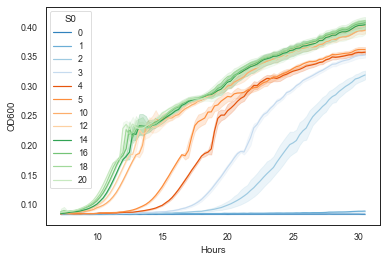

In [65]:
sns.lineplot(x='Hours',y='OD600',hue='S0',data=df[df.Hours > 7],palette="tab20c")

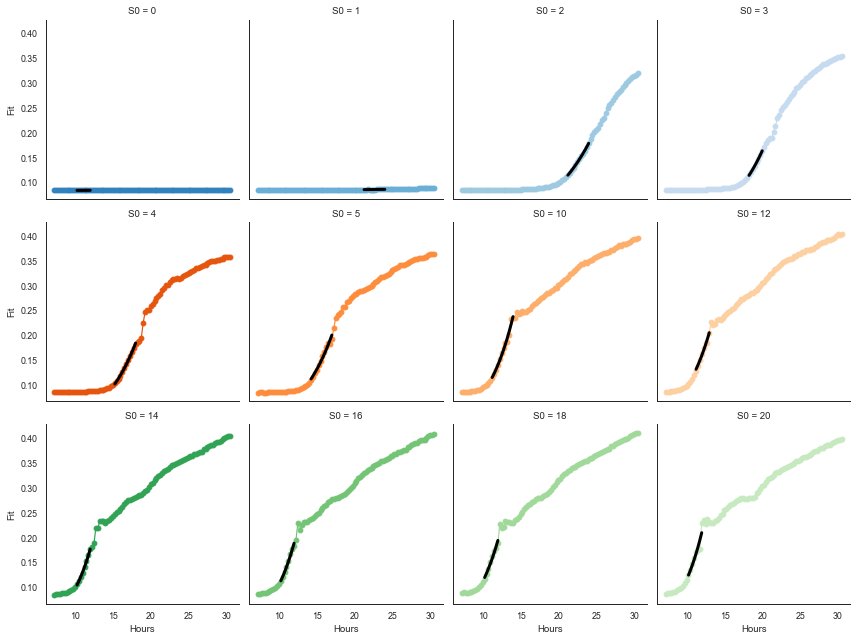

In [66]:
grid = sns.FacetGrid(df2[df2.Hours > 7],col='S0',col_wrap=4,hue='S0',palette="tab20c")
grid.map(plt.plot, "Hours", "OD600", marker="o")
grid.map(plt.plot, "Hours", "Fit", ls="-",color='k',lw=3)

<AxesSubplot:xlabel='S0', ylabel='mu'>

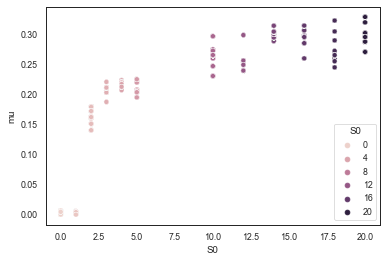

In [67]:
sns.scatterplot(x='S0',y='mu',hue='S0',data=df)

<AxesSubplot:xlabel='S0', ylabel='mu'>

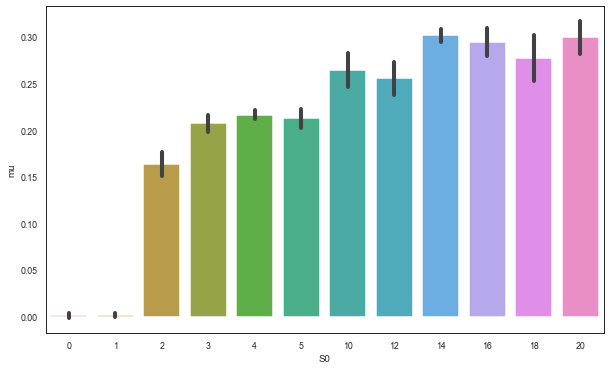

In [68]:
f,ax = plt.subplots(figsize=(10,6))
sns.set_context('talk')
sns.set_style('white')
sns.barplot(x='S0',y='mu',ci='sd',data=df,ax=ax)

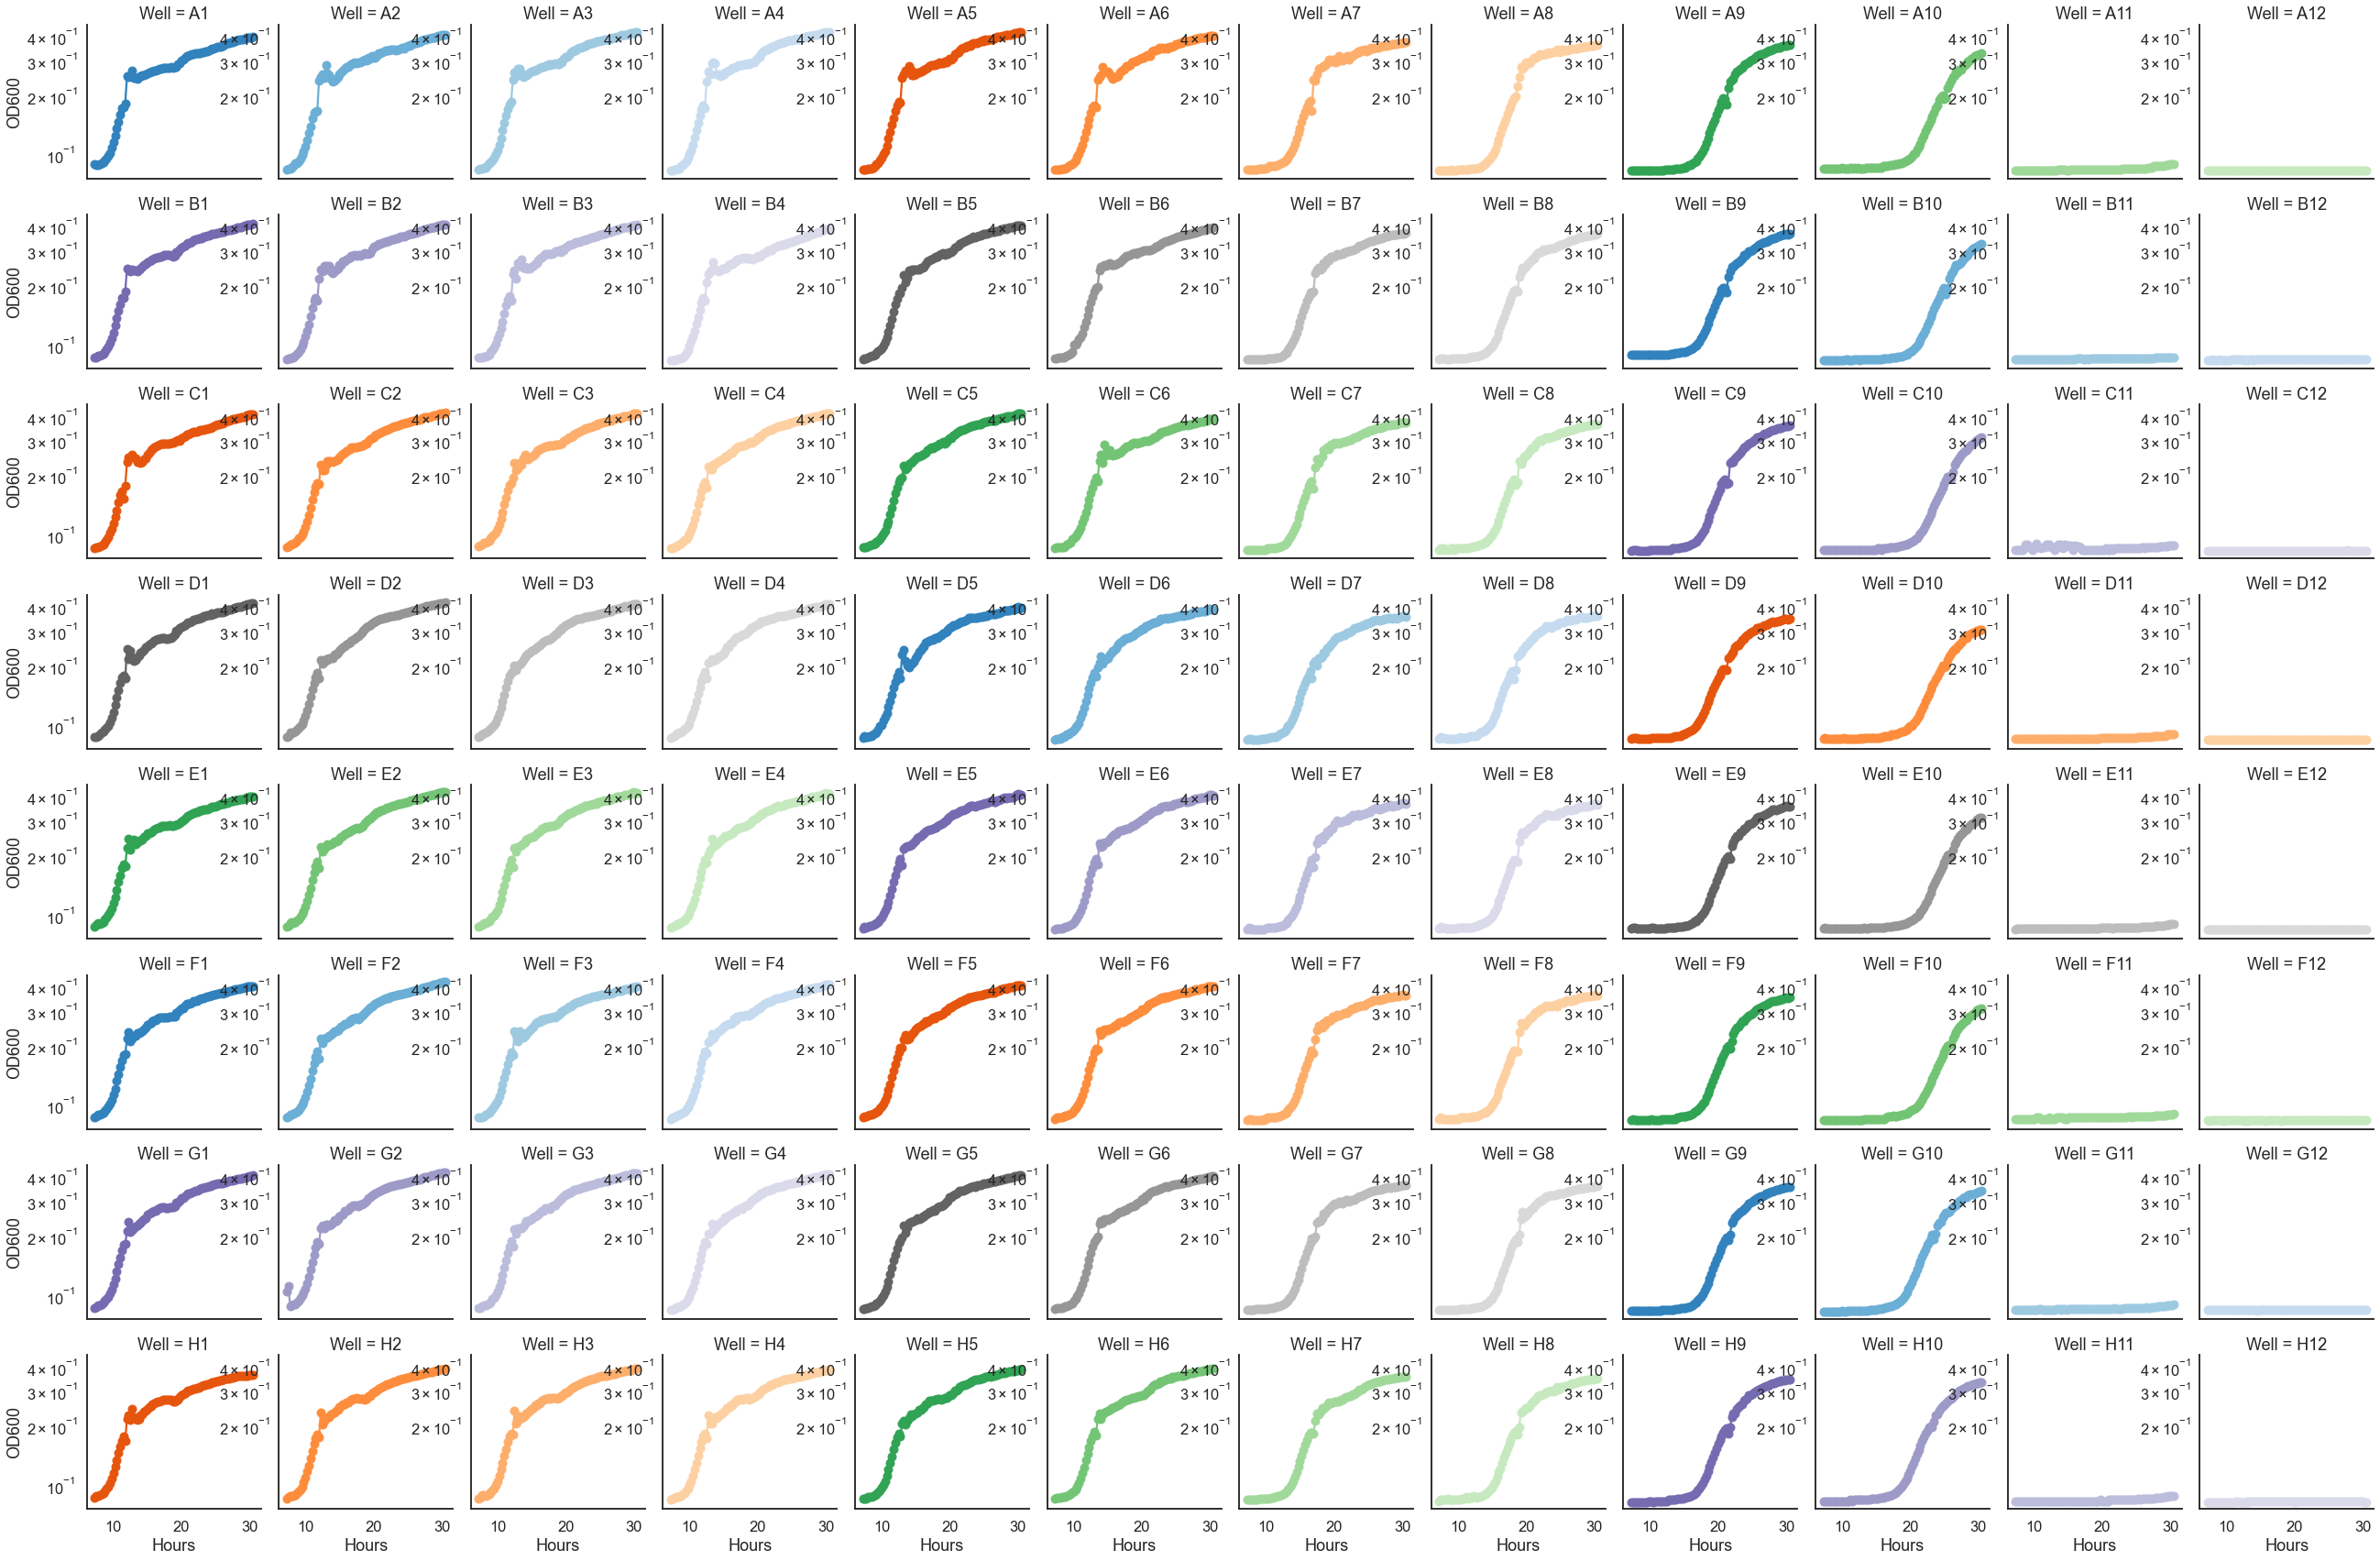

In [48]:
grid = sns.FacetGrid(df[df.Hours > 7],col='Well',col_wrap=12,hue='Well',palette="tab20c")
grid.map(plt.plot, "Hours", "OD600", marker="o").set(yscale = 'log')
#grid.map(plt.plot, "Hours", "Fit", ls=":").set(yscale = 'log')

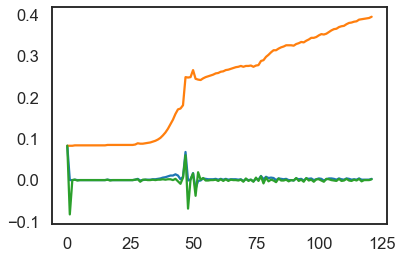

In [49]:
A1 = df[df.Well=='A1']
difference = np.diff(A1.OD600,prepend=0)
d2 = np.diff(difference,prepend=0)
plt.plot(difference)
plt.plot(A1.OD600)
plt.plot(d2)


In [50]:
data = utils.get_data(r'D:\runs\Run_0_100_12_1_2021-07-16')

In [51]:
data.avg_con

,O2,Sucrose,CO2
Hours,,,
0.000000,0.281250,5.842828e+01,0.679391
0.277778,0.281249,5.839068e+01,0.679392
0.555556,0.281249,5.835118e+01,0.679392
0.833333,0.281249,5.830973e+01,0.679392
1.111111,0.281249,5.826620e+01,0.679392
...,...,...,...
96.111111,0.281249,1.955348e-36,0.679392
96.388889,0.281249,1.455464e-36,0.679392
96.666667,0.281249,1.083694e-36,0.679392


In [52]:
Volume = 1e-4*1e-4*1e-5 #m^3
CellNum2OD = Volume/1e-9
df2 = pd.concat([data.ntypes.ecw*CellNum2OD,data.ntypes.step/60/60*data.timestep],axis=1)
df2.columns=['OD600','Hours']
SucroseMW = 342.3

In [53]:
df.groupby('S0').mean()['mu']

S0
0     0.001433
1     0.002010
2     0.163883
3     0.207408
4     0.216891
5     0.213029
10    0.264609
12    0.255564
14    0.301827
16    0.294783
18    0.277585
20    0.299615
Name: mu, dtype: float64

In [54]:
growthRates = {1 : 0.002,2:.163,5:.21,10:.265,20:.2996}

In [55]:
data.avg_con.Sucrose[0]*SucroseMW/1e3

20.0

[0.85153994 0.32024766 0.00115569]


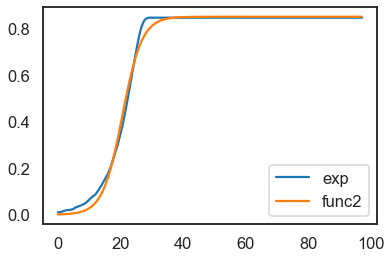

In [56]:
def grow(x,a,k,b):
    return a/(1+b*np.exp(x*k))

popt2, pcov2 = curve_fit(func,df2.Hours, df2.OD600)
print(popt2)
xrange= np.arange(0,df2.Hours.max(),1)

plt.plot(df2.Hours,df2.OD600,label='exp')
plt.plot(xrange,func(xrange,*popt2),label='func2')
plt.legend()